Time to Maturity is 0.0384


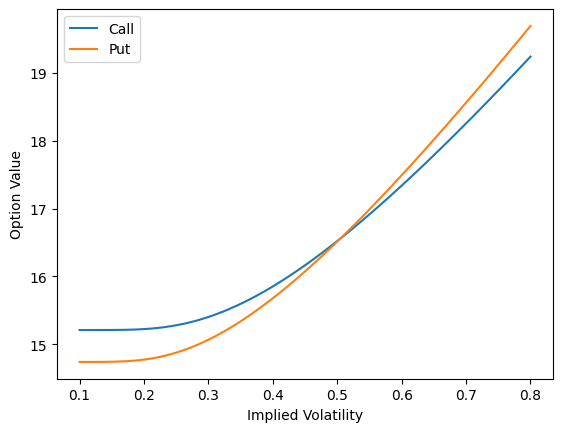

In [50]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy

class Option:
    def __init__(self, S, X, r, coupon, option_type):
        self.S = S
        self.X = X
        self.r = r
        self.coupon = coupon
        self.b = r - coupon
        self.option_type = option_type

    def time_to_maturity(self, current_date, exp_date):
        return (exp_date - current_date).days / 365

    def black_scholes_price(self, T, sigma):
        d1 = (np.log(self.S/self.X) + (self.b + (sigma**2)/2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if self.option_type == "Call":
            price = self.S * np.exp((self.b-self.r)*T) * norm.cdf(d1) - self.X * np.exp(-self.r*T) * norm.cdf(d2)
        else:
            price = self.X * np.exp(-self.r*T) * norm.cdf(-d2) - self.S * np.exp((self.b-self.r)*T) * norm.cdf(-d1)
        return price

S = 165
r = 0.0425
coupon = 0.0053
current_date = datetime(2023, 3, 3)
exp_date = datetime(2023, 3, 17)

call_option = Option(S, 150, r, coupon, "Call")
put_option = Option(S, 180, r, coupon, "Put")

ttm = call_option.time_to_maturity(current_date, exp_date)
print(f"Time to Maturity is {round(ttm, 4)}")

sigmas = np.linspace(0.1, 0.8, 70)
call_prices = [call_option.black_scholes_price(ttm, sigma) for sigma in sigmas]
put_prices = [put_option.black_scholes_price(ttm, sigma) for sigma in sigmas]

plt.plot(sigmas, call_prices, label="Call")
plt.plot(sigmas, put_prices, label="Put")
plt.xlabel("Implied Volatility")
plt.ylabel("Option Value")
plt.legend()
plt.show()


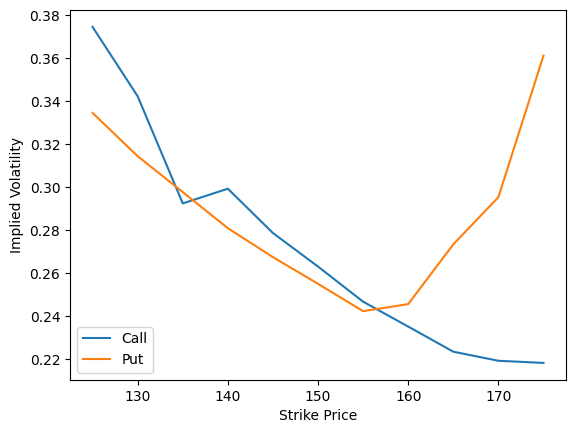

In [2]:

AAPL_options = pd.read_csv("AAPL_Options.csv", parse_dates=["Expiration"])
S = 151.03
r = 0.0425
coupon = 0.0053
current_date = datetime(2023, 3, 3)
exp_dates = AAPL_options["Expiration"]
strikes = AAPL_options["Strike"]
prices = AAPL_options["Last Price"]
types = AAPL_options["Type"]

call_strikes = []
call_ivs = []
put_strikes = []
put_ivs = []

for i in range(len(AAPL_options)):
    option_type = types[i]
    X = strikes[i]
    T = Option(S, X, r, coupon, option_type).time_to_maturity(current_date, exp_dates[i])
    price = prices[i]
    iv = brentq(lambda sigma: Option(S, X, r, coupon, option_type).black_scholes_price(T, sigma) - price, 1e-10, 2)
    if option_type == "Call":
        call_strikes.append(X)
        call_ivs.append(iv)
    else:
        put_strikes.append(X)
        put_ivs.append(iv)

plt.plot(call_strikes, call_ivs, label="Call")
plt.plot(put_strikes, put_ivs, label="Put")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()


In [24]:
portfolios = pd.read_csv("problem3.csv", parse_dates=["ExpirationDate"])
current_date = datetime(2023, 3, 3)

r = 0.0425
coupon = 0.0053
S = 151.03


def implied_vol(option_type, S, X, T, r, coupon, market_price, x0=0.5):
    def equation(sigma):
        return Option(S, X, r, coupon, option_type).black_scholes_price(T, sigma) - market_price
    
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

implied_vols = []
for i in range(len(portfolios.index)):
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = Option(S, X, r, coupon, option_type).time_to_maturity(current_date, portfolios["ExpirationDate"][i])
    market_price = portfolios["CurrentPrice"][i]
    sigma = implied_vol(option_type, S, X, T, r, coupon, market_price)
    implied_vols.append(sigma)

portfolios["ImpliedVol"] = implied_vols
#print(portfolios)




/Users/xuantingdong/Library/Mobile Documents/com~apple~CloudDocs/Duke/23SP/Fintech512/fintech512-assignments/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [44]:
def cal_port_value(portfolios, sim_prices, current_date):
    portfolio_values = pd.DataFrame(index=portfolios.index, columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in range(len(portfolios.index)):
        if portfolios["Type"][i] == "Stock":
            value = sim_prices
        else:
            option_type = portfolios["OptionType"][i]
            S = sim_prices
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days) / 365
            sigma = portfolios["ImpliedVol"][i]
            option = Option(S, X, r, coupon, option_type)
            option_values = option.black_scholes_price(T, sigma)
            value = option_values
        # Calculate the total values based on holding
        portfolio_values.loc[i, :] = portfolios["Holding"][i] * value
    # Combine the values for same portfolios
    portfolio_values['Portfolio'] = portfolios['Portfolio']
    return portfolio_values.groupby('Portfolio').sum()

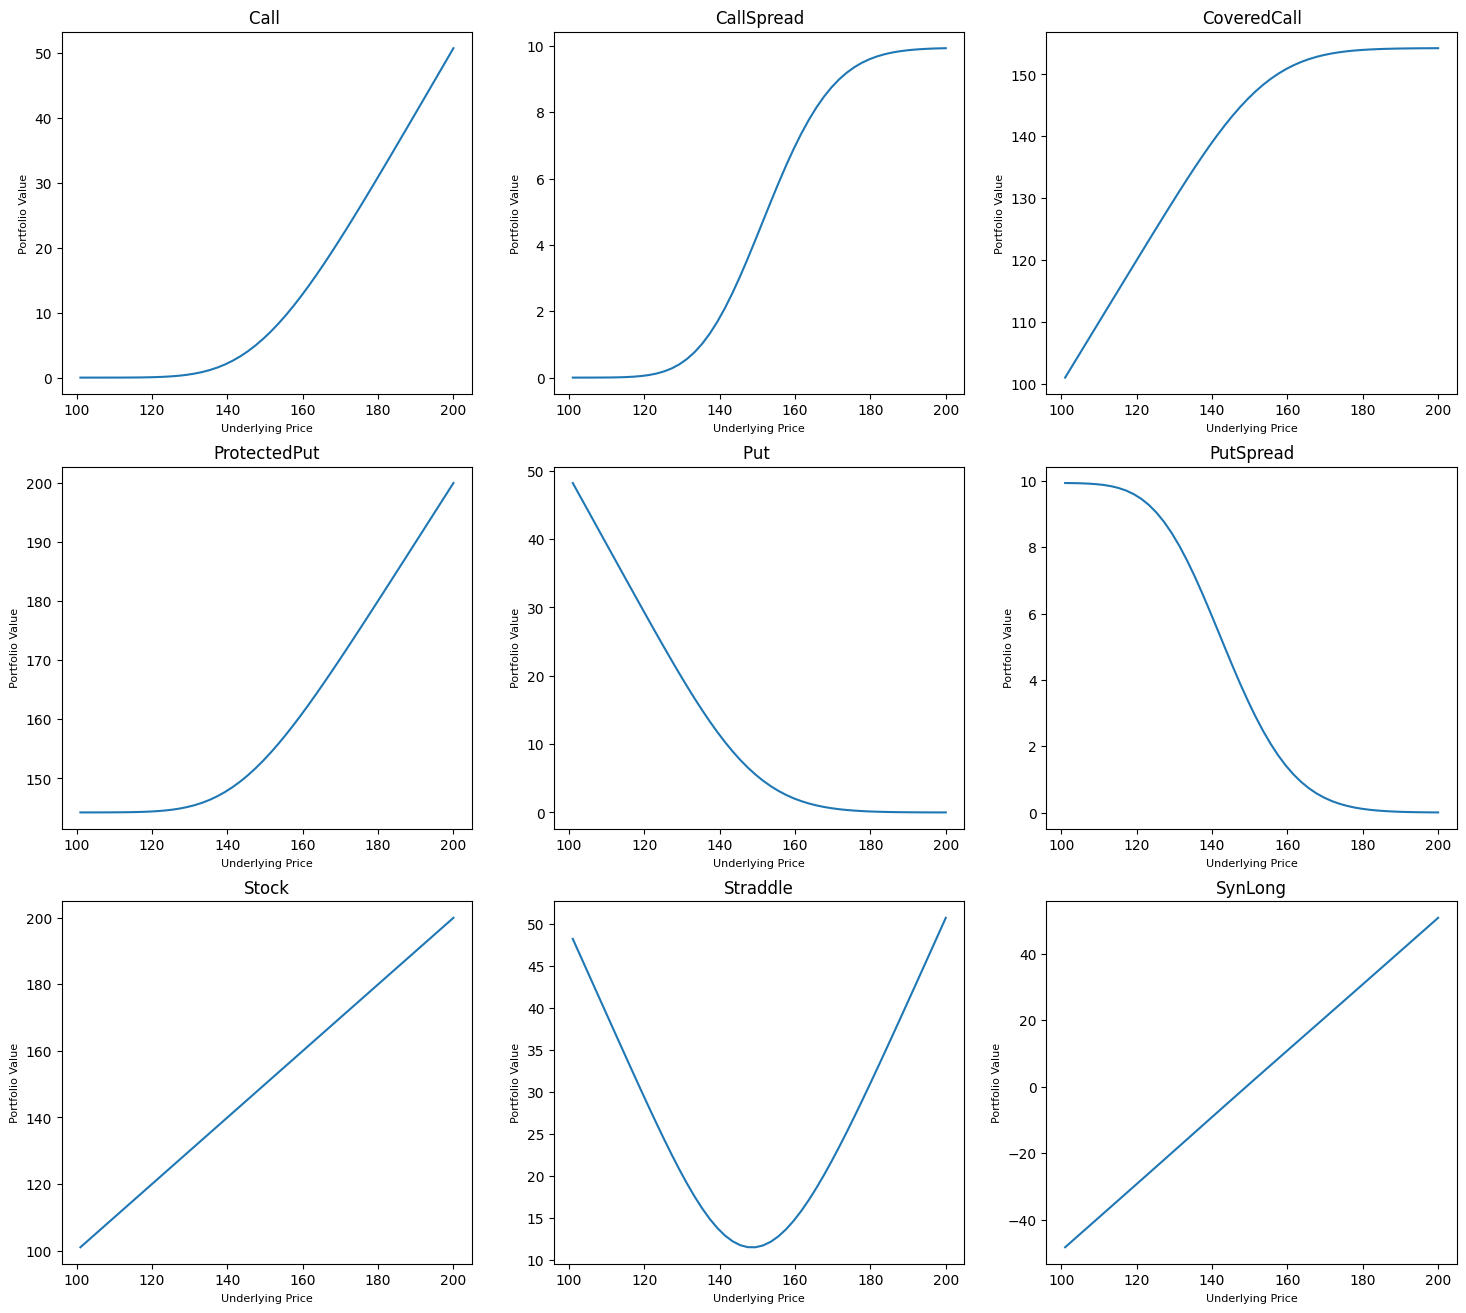

In [45]:
sim_prices = np.linspace(101, 200, 50)
# Calculate the stock and option values
portfolio_values = cal_port_value(portfolios, sim_prices, current_date)
# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in portfolio_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

In [26]:

DailyPrices = pd.read_csv('DailyPrices.csv')
aapl_prices = DailyPrices['AAPL']
log_returns = np.log(aapl_prices) - np.log(aapl_prices.shift(1))

demeaned_log_returns = log_returns - np.mean(log_returns)

# Fit an AR(1) model to the demeaned log returns
ar1_model = sm.tsa.ARIMA(demeaned_log_returns, order=(1,0,0))
result = ar1_model.fit()

simulated_log_returns = result.predict(start=len(demeaned_log_returns), end=len(demeaned_log_returns)+9, dynamic=True)
print(simulated_log_returns)

# Calculate the mean, VaR, and ES of the simulated log returns
mean = np.mean(simulated_log_returns)
var = np.percentile(simulated_log_returns, 5)
es = np.mean(simulated_log_returns[simulated_log_returns <= var])

result = pd.DataFrame({'mean': [mean], 'var': [var], 'es': [es]})
print(result)


249    3.029239e-04
250   -1.557714e-05
251   -6.633360e-07
252   -1.361675e-06
253   -1.328975e-06
254   -1.330506e-06
255   -1.330435e-06
256   -1.330438e-06
257   -1.330438e-06
258   -1.330438e-06
Name: predicted_mean, dtype: float64
       mean       var        es
0  0.000028 -0.000009 -0.000016
